In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/isec-sdc-2025/train.csv
/kaggle/input/isec-sdc-2025/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
import warnings
warnings.filterwarnings('ignore')
nltk.download('omw-1.4', quiet=True)
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (17,7)
plt.rcParams['font.size'] = 18

# Data Laoding

In [4]:
data = pd.read_csv('/kaggle/input/isec-sdc-2025/train.csv')
test = pd.read_csv('/kaggle/input/isec-sdc-2025/test.csv')
data.head(5)

Issue_id          Component  \
0      1700             Layout   
1      7991           Plug-ins   
2      1150              XPCOM   
3      6143                XUL   
4      5952  Networking: Cache   

                                               Title  \
0      font size 9px rounded down to 8px {font} {ll}   
1  Land OOP plugins in mozilla-central (preffed off)   
2  XP-COM Proxy code crashes when trying to AutoP...   
3  crash setting display:none on grid rows [@ nsG...   
4       limit the memory cache to a reasonable value   

                                         Description    Status Resolution  \
0  There is a piece of code in the Windows GFX th...  VERIFIED      FIXED   
1  We need to land OOP plugins in mozilla-central...  RESOLVED      FIXED   
2  (This bug imported from BugSplat; Netscapes in...  VERIFIED      FIXED   
3  User-Agent:       Mozilla/5.0 (Windows; U; Win...  VERIFIED      FIXED   
4  I have 1GB of RAM; so Im using 31MB of memory ...  VERIFIED      FIXED   

   Priority  
0         0  
1         0  
2         0  
3         0  
4         0

In [5]:
data.iloc[690]['Title']

'Optimize JS function/method calling bytecodes'

In [6]:
data['Priority'].value_counts()


Priority
2    31154
1     9412
0     8943
3     2287
4     1198
Name: count, dtype: int64

In [7]:
data.shape

(52994, 7)

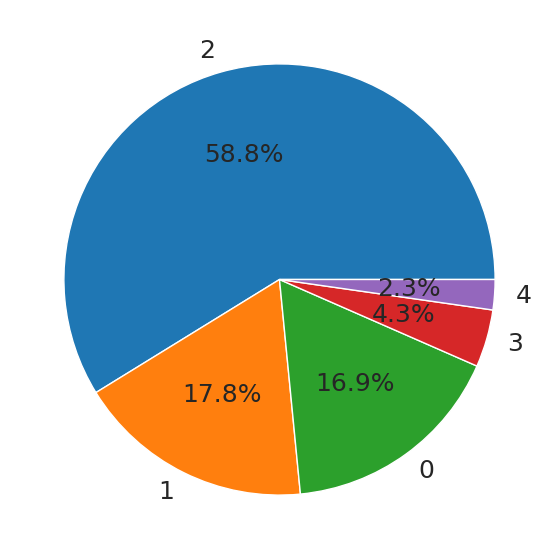

In [8]:

plt.pie(data['Priority'].value_counts(), labels=[2,1,0,3,4], autopct='%1.1f%%')
plt.show()

# Categorical Features

## Component Feature

In [9]:
num_components = data['Component'].nunique()
print(f"There are {num_components} unique components in the dataset.")


There are 183 unique components in the dataset.


In [10]:
component_counts = data['Component'].value_counts()
print(component_counts.head(20))


Component
Layout                         6129
XUL                            4176
Editor                         3043
JavaScript Engine              2513
Networking                     2417
Layout: Tables                 2027
Layout: Form Controls          1810
CSS Parsing and Computation    1696
HTML: Parser                   1656
Plug-ins                       1552
Security: UI                   1539
DOM: Core & HTML               1517
Internationalization           1447
XPCOM                          1347
Event Handling                 1044
DOM                            1000
ImageLib                        808
HTML: Form Submission           791
Tracking                        750
Installer: XPInstall Engine     714
Name: count, dtype: int64


Components contributing to 80% of the data:
Component
Layout                         6129
XUL                            4176
Editor                         3043
JavaScript Engine              2513
Networking                     2417
Layout: Tables                 2027
Layout: Form Controls          1810
CSS Parsing and Computation    1696
HTML: Parser                   1656
Plug-ins                       1552
Security: UI                   1539
DOM: Core & HTML               1517
Internationalization           1447
XPCOM                          1347
Event Handling                 1044
DOM                            1000
ImageLib                        808
HTML: Form Submission           791
Tracking                        750
Installer: XPInstall Engine     714
Document Navigation             706
Printing: Output                646
UI                              577
Bookmarks & History             555
Layout: HTML Frames             516
Security                        478
Profile: B

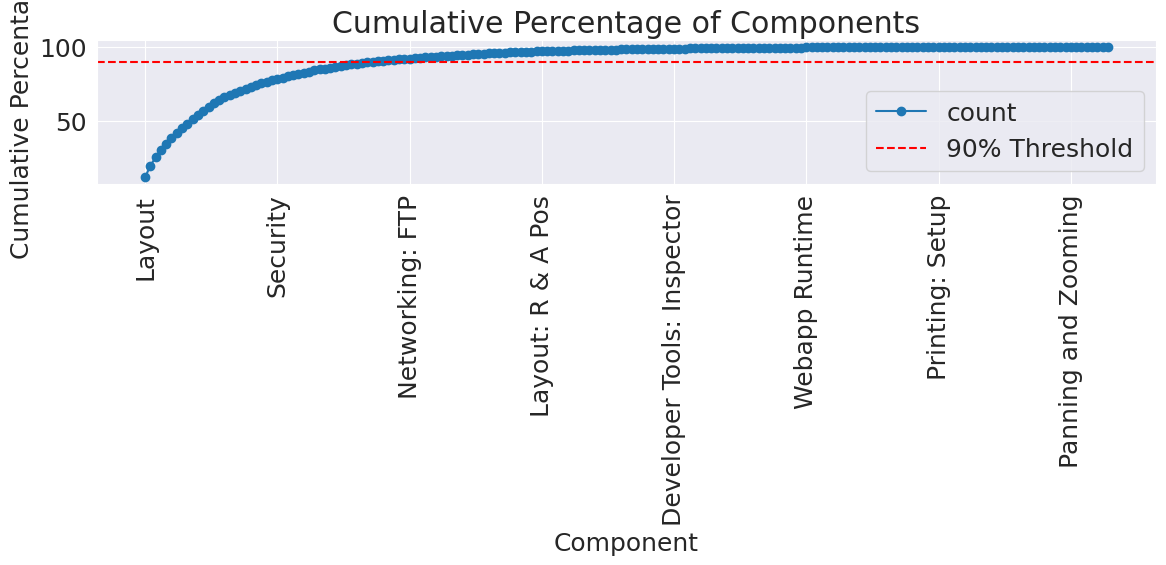

In [11]:
# Calculate the value counts for components
component_counts = data['Component'].value_counts()

# Calculate cumulative percentage
cumulative_percentage = component_counts.cumsum() / component_counts.sum() * 100

# Filter components contributing to 80% or less cumulative percentage
top_components_80 = cumulative_percentage[cumulative_percentage <= 90].index.tolist()

# Display the components and their cumulative percentages
print("Components contributing to 80% of the data:")
print(component_counts.loc[top_components_80],len(component_counts.loc[top_components_80]))

# Plot cumulative percentage curve (optional, for visualization)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
cumulative_percentage.plot(kind='line', marker='o')
plt.axhline(90, color='r', linestyle='--', label='90% Threshold')
plt.title('Cumulative Percentage of Components')
plt.xlabel('Component')
plt.ylabel('Cumulative Percentage')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


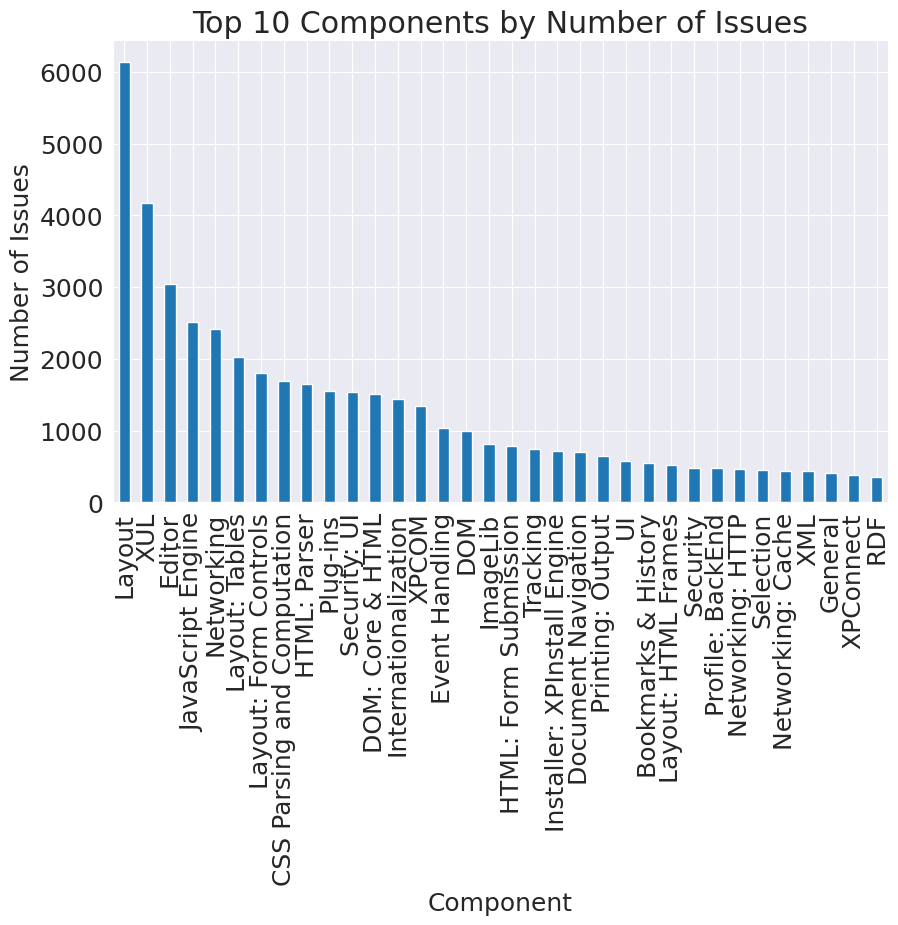

In [12]:
import matplotlib.pyplot as plt

top_components = component_counts.head(34)
top_components.plot(kind='bar', figsize=(10,6))
plt.title('Top 10 Components by Number of Issues')
plt.xlabel('Component')
plt.ylabel('Number of Issues')
plt.xticks(rotation=90)
plt.show()


In [13]:
component_priority = pd.crosstab(data['Component'], data['Priority'])
print(component_priority.head(20))  # Show top 10 for brevity


Priority                       0    1     2    3   4
Component                                           
Account Manager               14    5     6    1   1
Address Book                   3    1     5    1   1
Bookmarks & History            9  219   169  122  36
Build Config                  57   51    37    6  15
CSS Parsing and Computation  223  399   928  112  34
Canvas: 2D                    13   34    14   10  10
Canvas: WebGL                  6    3     2    2   3
Compare                        0    4     8    6   0
DMD                            1    0     0    0   0
DOM                          328  293   341   26  12
DOM: Apps                     31    8     1    1   0
DOM: CSS Object Model         31   28    98   12   3
DOM: Contacts                  1    0     0    0   0
DOM: Core & HTML             206  211  1010   63  27
DOM: Device Interfaces        95   28     4    2   1
DOM: Events                   43   36    56   19   9
DOM: IndexedDB                 8    0     0   

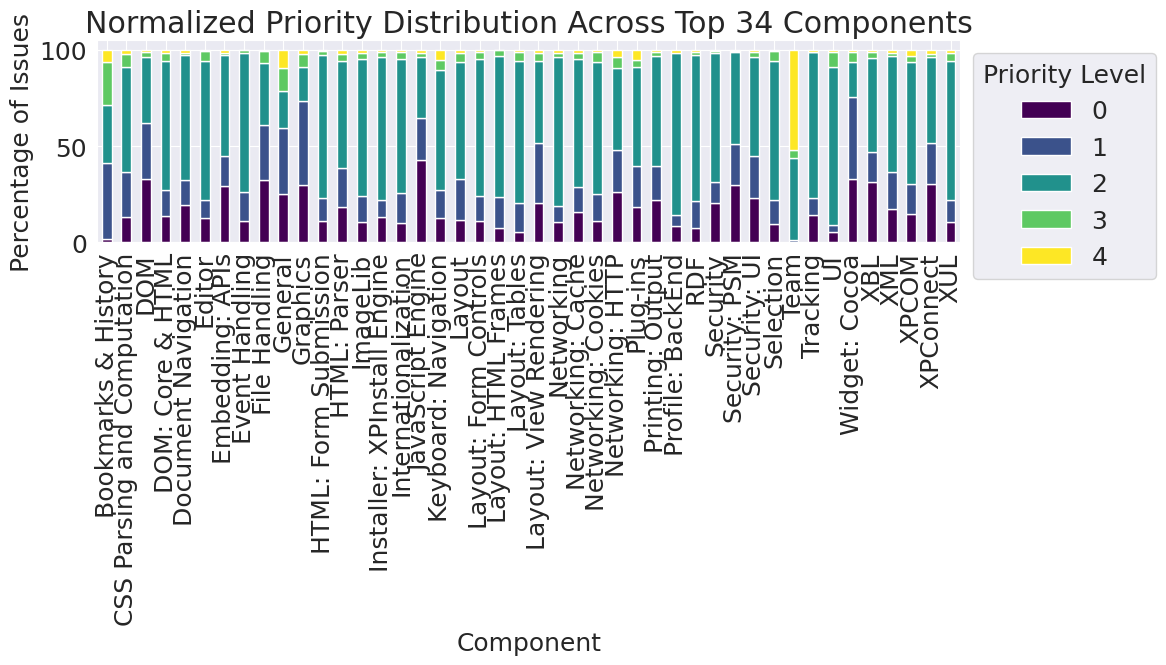

In [14]:
# Get the top 20 components
top_components_list = component_counts.head(44).index.tolist()
filtered_data = data[data['Component'].isin(top_components_list)]

# Create a crosstab for component vs priority
component_priority = pd.crosstab(filtered_data['Component'], filtered_data['Priority'])

# Normalize the crosstab to percentages
component_priority_normalized = component_priority.div(component_priority.sum(axis=1), axis=0) * 100

# Plot the normalized values
component_priority_normalized.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis')
plt.title('Normalized Priority Distribution Across Top 34 Components')
plt.xlabel('Component')
plt.ylabel('Percentage of Issues')
plt.legend(title='Priority Level', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


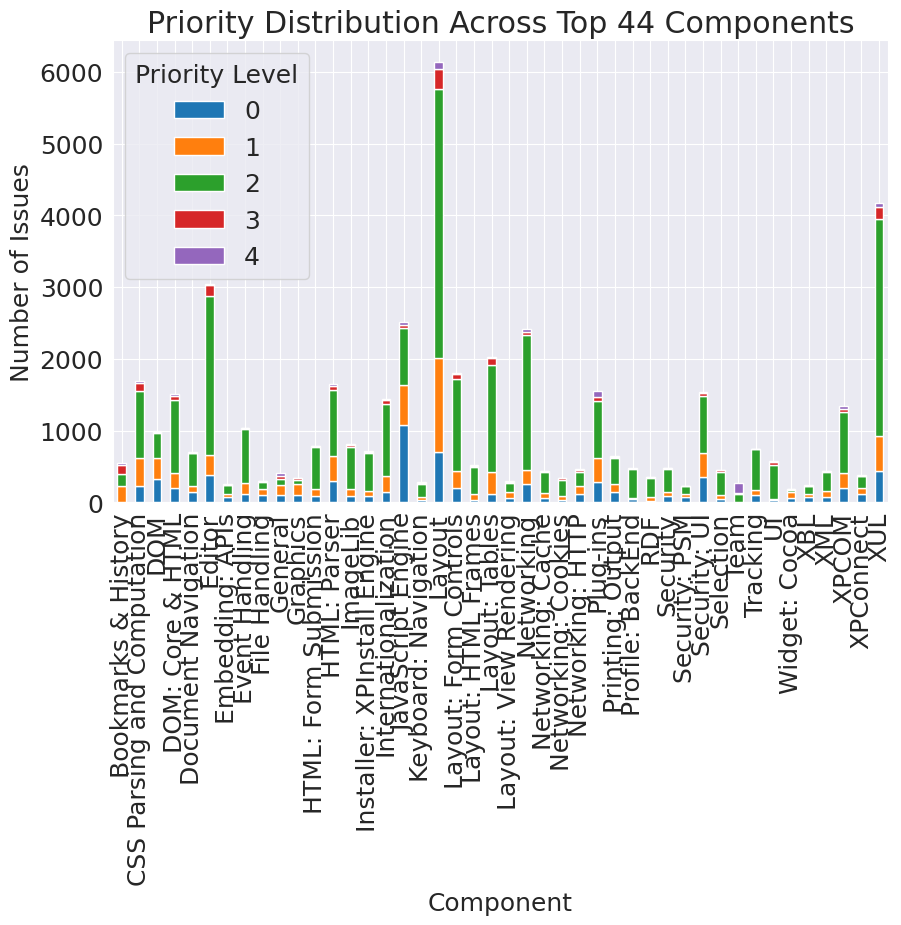

In [15]:
# Plotting the relationship for the top 5 components
top_components_list = component_counts.head(44).index.tolist()
filtered_data = data[data['Component'].isin(top_components_list)]

component_priority = pd.crosstab(filtered_data['Component'], filtered_data['Priority'])
component_priority.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Priority Distribution Across Top 44 Components')
plt.xlabel('Component')
plt.ylabel('Number of Issues')
plt.legend(title='Priority Level')
plt.xticks(rotation=90)
plt.show()


## Status

In [16]:
status_counts = data['Status'].value_counts()
print(status_counts)


Status
VERIFIED    34258
RESOLVED    18396
CLOSED        340
Name: count, dtype: int64


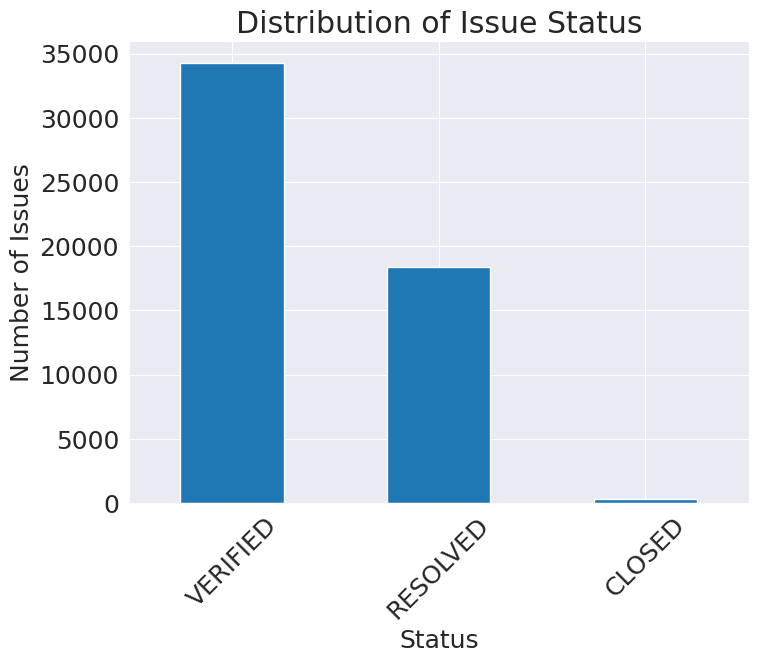

In [17]:
status_counts.plot(kind='bar', figsize=(8,6))
plt.title('Distribution of Issue Status')
plt.xlabel('Status')
plt.ylabel('Number of Issues')
plt.xticks(rotation=45)
plt.show()


Normalized Priority Distribution Across Status:
Priority          0          1          2         3         4
Status                                                       
CLOSED     8.529412  13.235294  75.882353  1.176471  1.176471
RESOLVED  22.999565  24.032398  39.981518  8.121331  4.865188
VERIFIED  13.669800  14.437504  68.716796  2.303112  0.872789


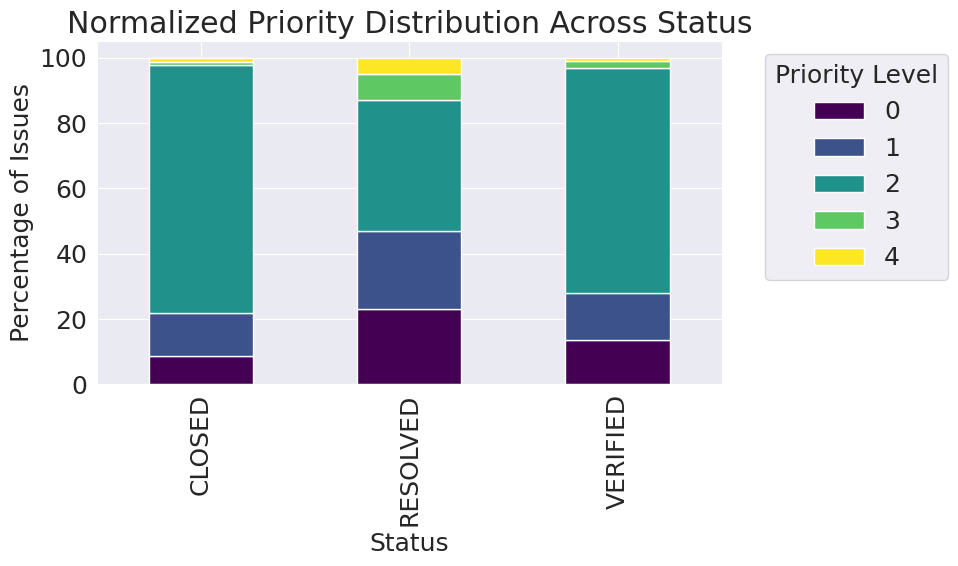

In [18]:
# Create a crosstab for Status vs Priority
status_priority = pd.crosstab(data['Status'], data['Priority'])

# Normalize the crosstab to percentages
status_priority_normalized = status_priority.div(status_priority.sum(axis=1), axis=0) * 100

# Print the normalized table
print("Normalized Priority Distribution Across Status:")
print(status_priority_normalized)

# Plot the normalized values
status_priority_normalized.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Normalized Priority Distribution Across Status')
plt.xlabel('Status')
plt.ylabel('Percentage of Issues')
plt.legend(title='Priority Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Resolution

In [19]:
resolution_counts = data['Resolution'].value_counts()
print(resolution_counts)


Resolution
FIXED         28647
DUPLICATE     10367
WORKSFORME     7742
INVALID        3687
WONTFIX        2208
INCOMPLETE      257
NDUPLICATE       73
EXPIRED           8
MOVED             5
Name: count, dtype: int64


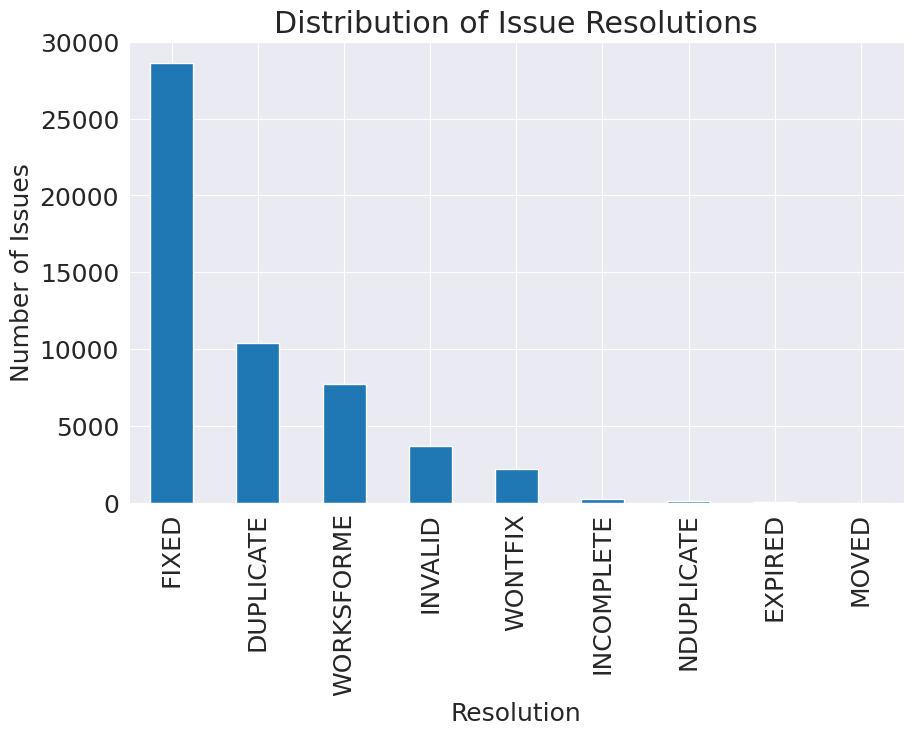

In [20]:
resolution_counts.plot(kind='bar', figsize=(10,6))
plt.title('Distribution of Issue Resolutions')
plt.xlabel('Resolution')
plt.ylabel('Number of Issues')
plt.xticks(rotation=90)
plt.show()


Normalized Priority Distribution Across Resolutions (Sorted by Frequency):
Priority       0     1      2     3    4
Resolution                              
DUPLICATE    786   953   8131   324  173
EXPIRED        0     2      6     0    0
FIXED       7055  6630  13366  1163  433
INCOMPLETE    41    55     93    22   46
INVALID      246   374   2749   143  175
MOVED          2     2      1     0    0
NDUPLICATE     3     4     51     3   12
WONTFIX      137   289   1358   222  202
WORKSFORME   673  1103   5399   410  157


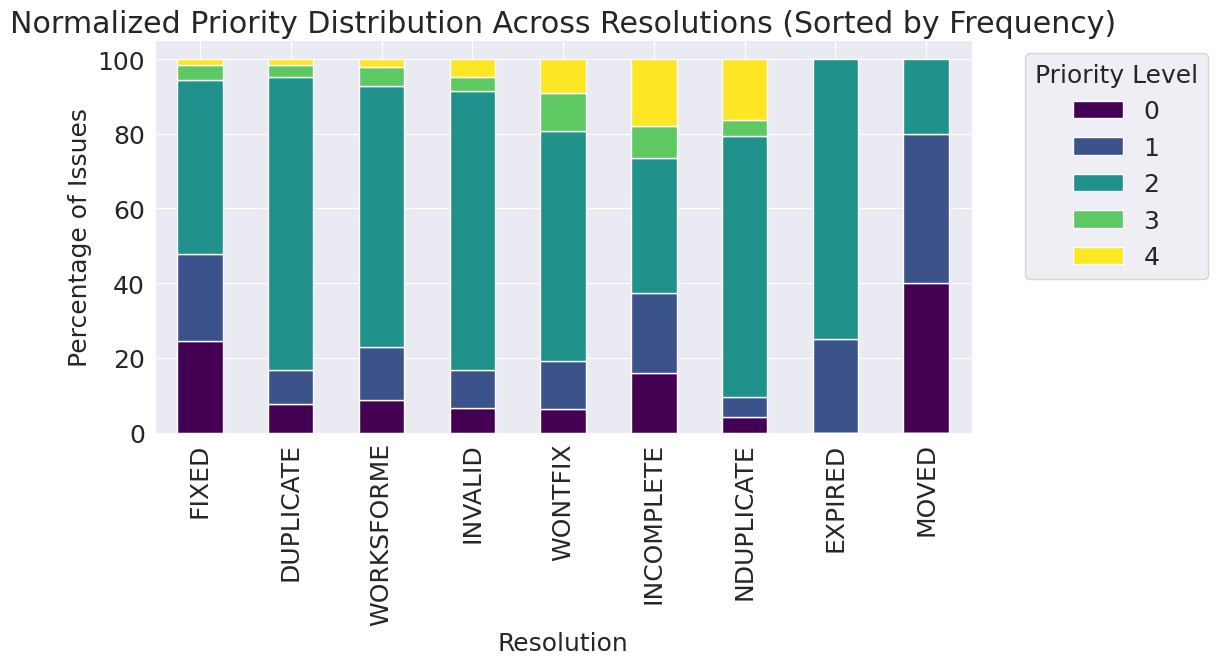

In [21]:
# Create a crosstab for Resolution vs Priority
resolution_priority = pd.crosstab(data['Resolution'], data['Priority'])

# Normalize the crosstab to percentages
resolution_priority_normalized = resolution_priority.div(resolution_priority.sum(axis=1), axis=0) * 100

# Sort the resolutions based on their total frequency
sorted_indices = resolution_priority.sum(axis=1).sort_values(ascending=False).index
resolution_priority_normalized = resolution_priority_normalized.loc[sorted_indices]

# Print the normalized table
print("Normalized Priority Distribution Across Resolutions (Sorted by Frequency):")
print(resolution_priority)

# Plot the normalized values
resolution_priority_normalized.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis')
plt.title('Normalized Priority Distribution Across Resolutions (Sorted by Frequency)')
plt.xlabel('Resolution')
plt.ylabel('Percentage of Issues')
plt.legend(title='Priority Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


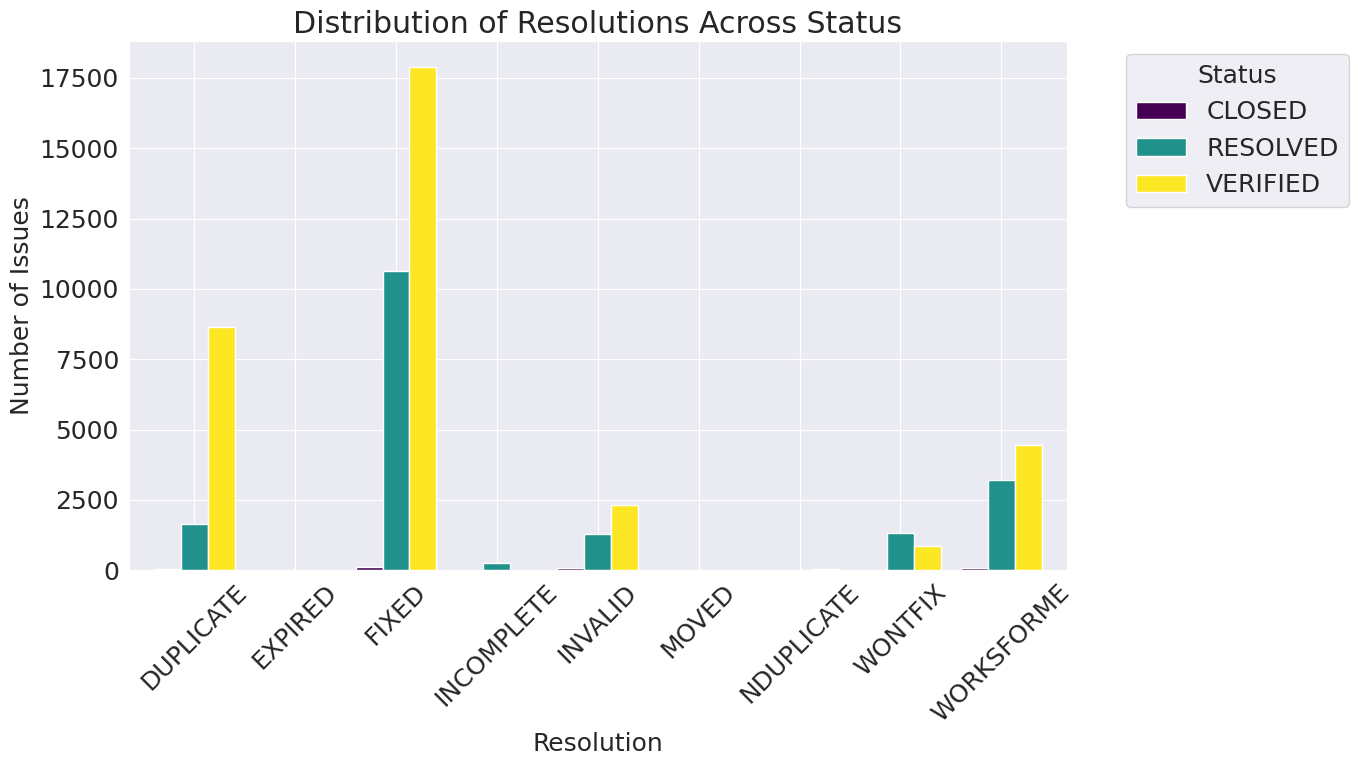

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a crosstab for Status vs Resolution
status_resolution = pd.crosstab(data['Status'], data['Resolution'])

# Plot a grouped bar chart
status_resolution.T.plot(kind='bar', figsize=(14, 8), colormap='viridis', width=0.8)
plt.title('Distribution of Resolutions Across Status')
plt.xlabel('Resolution')
plt.ylabel('Number of Issues')
plt.legend(title='Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Title

In [23]:
import re
import string


In [24]:
def preprocess_title(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove links
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Define punctuations to keep
    punct_to_keep = [':', '>', '<', '=']
    
    # Remove punctuations except the ones to keep
    punctuations = string.punctuation
    punct_to_remove = ''.join([p for p in punctuations if p not in punct_to_keep])
    text = text.translate(str.maketrans('', '', punct_to_remove))
    
    return text


In [25]:
data['cleaned_title'] = data['Title'].apply(preprocess_title)

In [26]:
for i in range(850,855):
    print(f"Original Title {i+1}: {data['Title'].iloc[i]}")
    print(f"Cleaned Title {i+1}: {data['cleaned_title'].iloc[i]}\n")


Original Title 851: npruntime NPN_HasMethod forwards to wrong plugin function (hasProperty)
Cleaned Title 851: npruntime npnhasmethod forwards to wrong plugin function hasproperty

Original Title 852: Uncontrolled recursion in js_MarkXML during GC
Cleaned Title 852: uncontrolled recursion in jsmarkxml during gc

Original Title 853: crash when quitting firefox after completing the peer connection test page [@ nsTimerEvent::scalar deleting destructor]
Cleaned Title 853: crash when quitting firefox after completing the peer connection test page  nstimerevent::scalar deleting destructor

Original Title 854: Ctrl+letter keyboard shortcuts dont work on Windows CE
Cleaned Title 854: ctrlletter keyboard shortcuts dont work on windows ce

Original Title 855: [FIXr]Make parser list in cssloader a class static
Cleaned Title 855: fixrmake parser list in cssloader a class static



In [27]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
def preprocess_title(text):
    # Previous preprocessing steps
    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)
    punct_to_keep = [':', '>', '<', '=']
    punctuations = string.punctuation
    punct_to_remove = ''.join([p for p in punctuations if p not in punct_to_keep])
    text = text.translate(str.maketrans('', '', punct_to_remove))
    
    # Tokenize and remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)
    
    return text


In [29]:
data['cleaned_title'] = data['Title'].apply(preprocess_title)


In [30]:
for i in range(5,10):
    print(f"Cleaned Title {i+1}: {data['cleaned_title'].iloc[i]}\n")


Cleaned Title 6: protocol handling dialog

Cleaned Title 7: tab widget showing html elements tabs

Cleaned Title 8: broken links mozillafirefox

Cleaned Title 9: trunk n610 crash nskeygenformprocessor::init

Cleaned Title 10: browser regressions ecma3operators11131001js js15regressregress252892js js15regressregress321757js



In [31]:
from collections import Counter

# Combine all cleaned titles into one text
all_words = ' '.join(data['cleaned_title']).split()

# Get word frequencies
word_freq = Counter(all_words)


In [32]:
rare_words = set(word for word, freq in word_freq.items() if freq == 1)


In [33]:
list(rare_words)[:5]

['proxyable',
 'nsdevicecontextxlibcpp:71:',
 'framewidth',
 'napak',
 'softpediacom']

In [34]:
def preprocess_title(text):
    # Previous preprocessing steps
    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)
    punct_to_keep = [':', '>', '<', '=']
    punctuations = string.punctuation
    punct_to_remove = ''.join([p for p in punctuations if p not in punct_to_keep])
    text = text.translate(str.maketrans('', '', punct_to_remove))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    # Remove rare words
    words = [word for word in words if word_freq[word] > 1]
    text = ' '.join(words)
    
    return text


In [35]:
data['cleaned_title'] = data['Title'].apply(preprocess_title)


### Lemmatization

In [36]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def preprocess_title_stemmer(text):
    # Previous preprocessing steps
    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)
    punct_to_keep = [':', '>', '<', '=']
    punctuations = string.punctuation
    punct_to_remove = ''.join([p for p in punctuations if p not in punct_to_keep])
    text = text.translate(str.maketrans('', '', punct_to_remove))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [word for word in words if word_freq[word] > 1]

    # Apply stemming
    stemmed_words = [stemmer.stem(word) for word in words]
    text = ' '.join(stemmed_words)

    return text

data['cleaned_title'] = data['Title'].apply(preprocess_title_stemmer)


### Word Counts

In [37]:
data['title_length'] = data['cleaned_title'].apply(len)
data['word_count'] = data['cleaned_title'].apply(lambda x: len(x.split()))


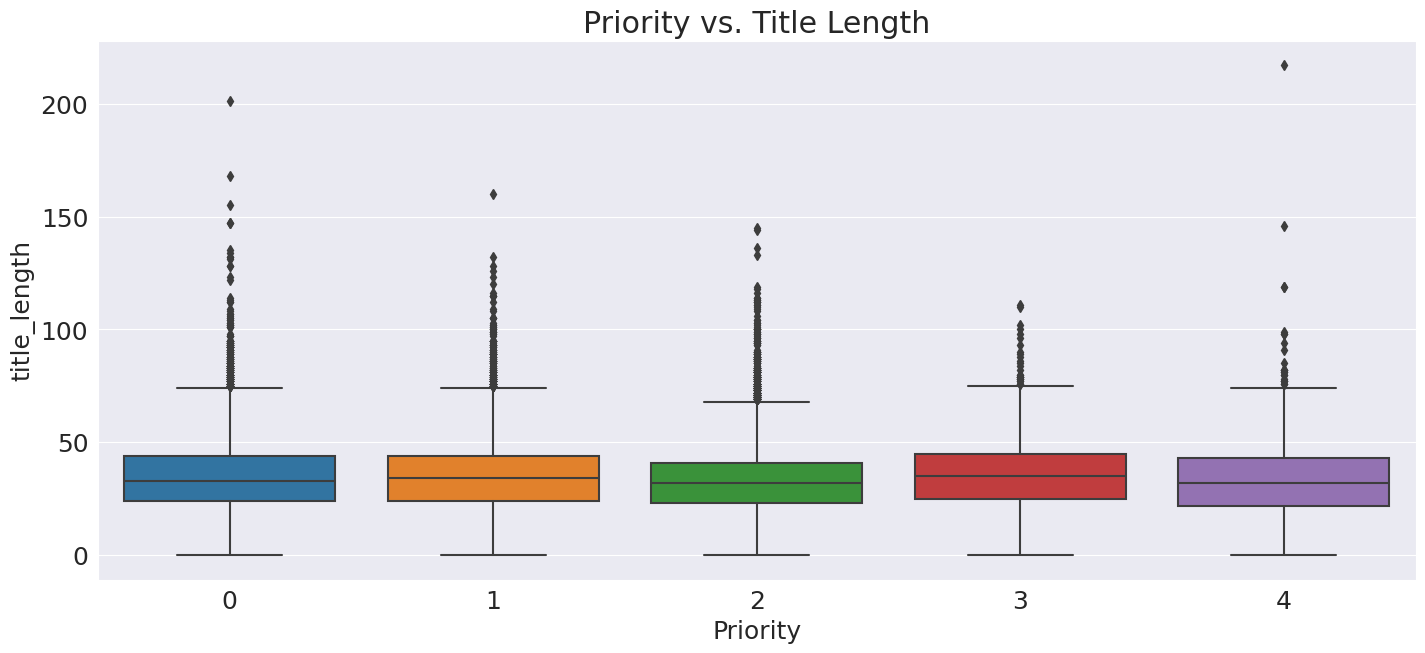

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='Priority', y='title_length', data=data)
plt.title('Priority vs. Title Length')
plt.show()



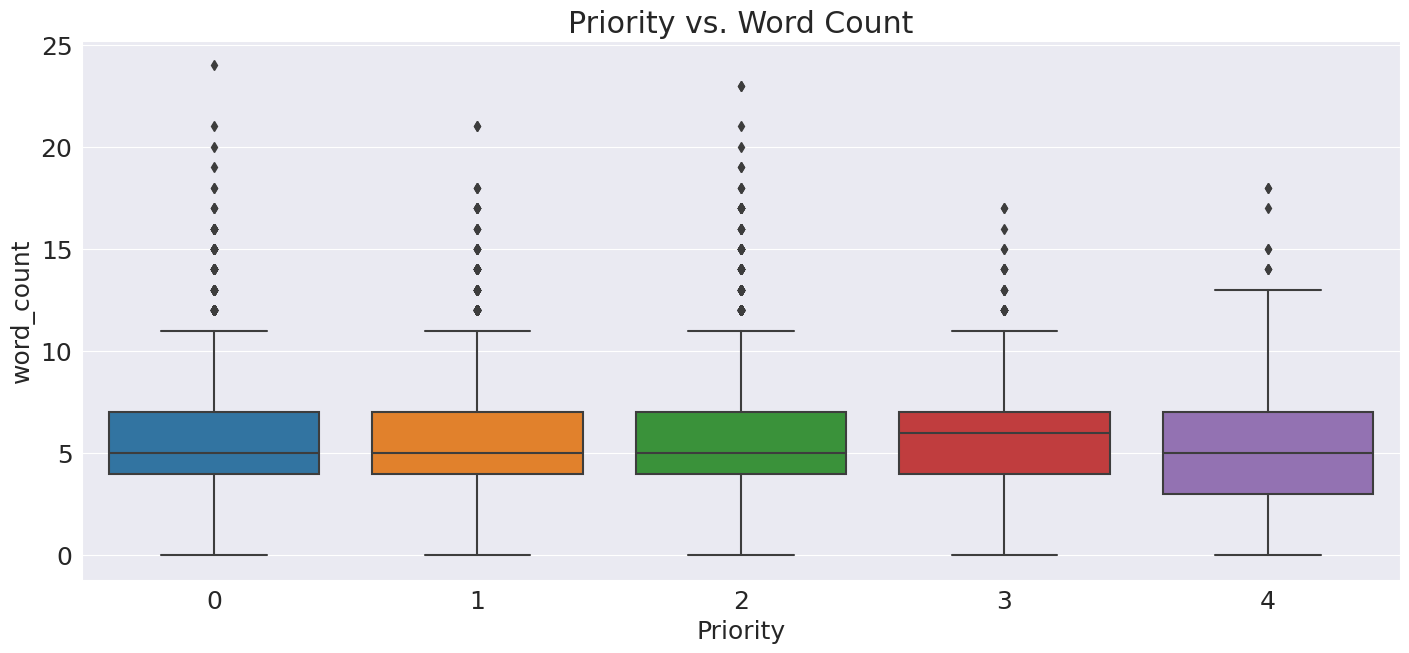

In [39]:
sns.boxplot(x='Priority', y='word_count', data=data)
plt.title('Priority vs. Word Count')
plt.show()


### Polarity

In [40]:
from textblob import TextBlob
data['polarity'] = data['cleaned_title'].apply(lambda x: TextBlob(x).sentiment.polarity)


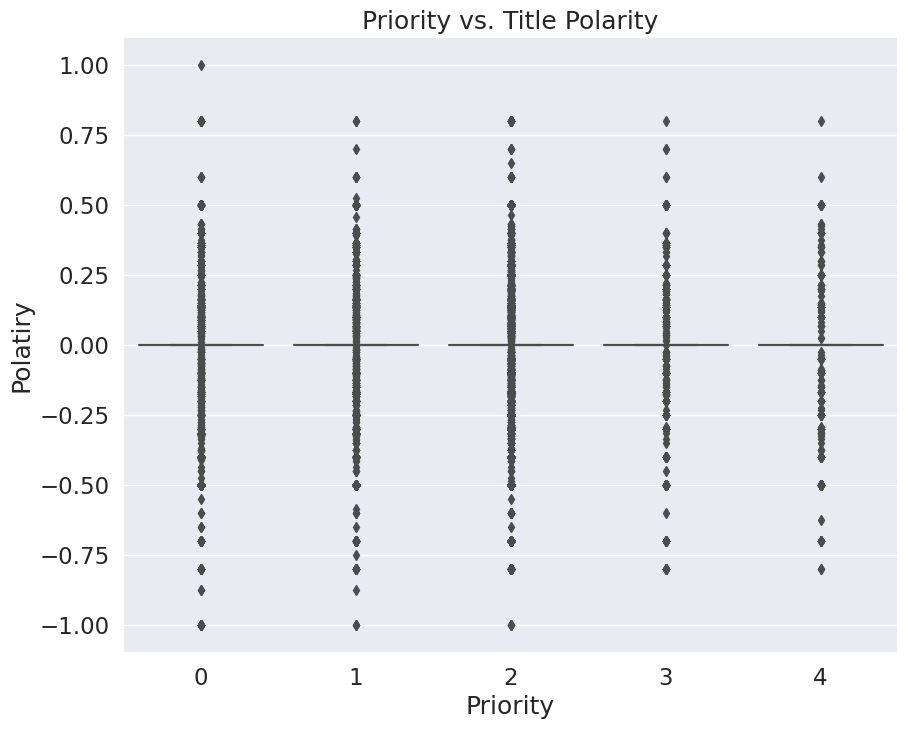

In [41]:
plt.figure(figsize = (10, 8))
sns.set_style('whitegrid')
sns.set(font_scale = 1.5)
sns.boxplot(x = 'Priority', y = 'polarity', data = data)
plt.xlabel("Priority")
plt.ylabel("Polatiry")
plt.title("Priority vs. Title Polarity")
plt.show()

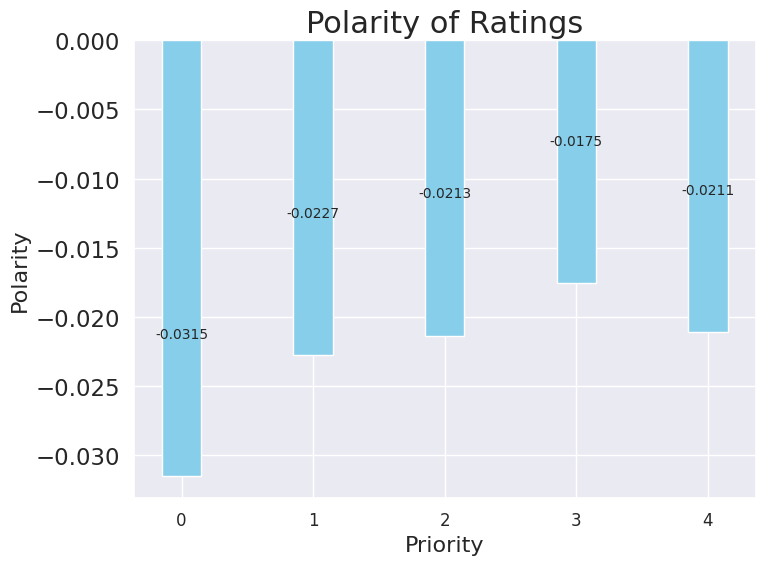

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Group data by 'Priority' and calculate the mean of 'polarity'
mean_pol = data.groupby('Priority')['polarity'].agg([np.mean])
mean_pol.columns = ['mean_polarity']

# Initialize the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Create a bar plot
ax.bar(mean_pol.index, mean_pol['mean_polarity'], width=0.3, color='skyblue')

# Add text annotations above the bars
for i in ax.patches:
    ax.text(i.get_x() + i.get_width() / 2,  # Center of the bar
            i.get_height() + 0.01,        # Slightly above the bar
            f"{i.get_height():.4f}",      # Height value formatted to 2 decimals
            ha='center', fontsize=10)

# Set the title and labels
ax.set_title("Polarity of Ratings", fontsize=22)
ax.set_ylabel("Polarity", fontsize=16)
ax.set_xlabel("Priority", fontsize=16)

# Adjust the x-axis tick labels
ax.set_xticks(mean_pol.index)
ax.set_xticklabels(mean_pol.index, fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


### WordCloud

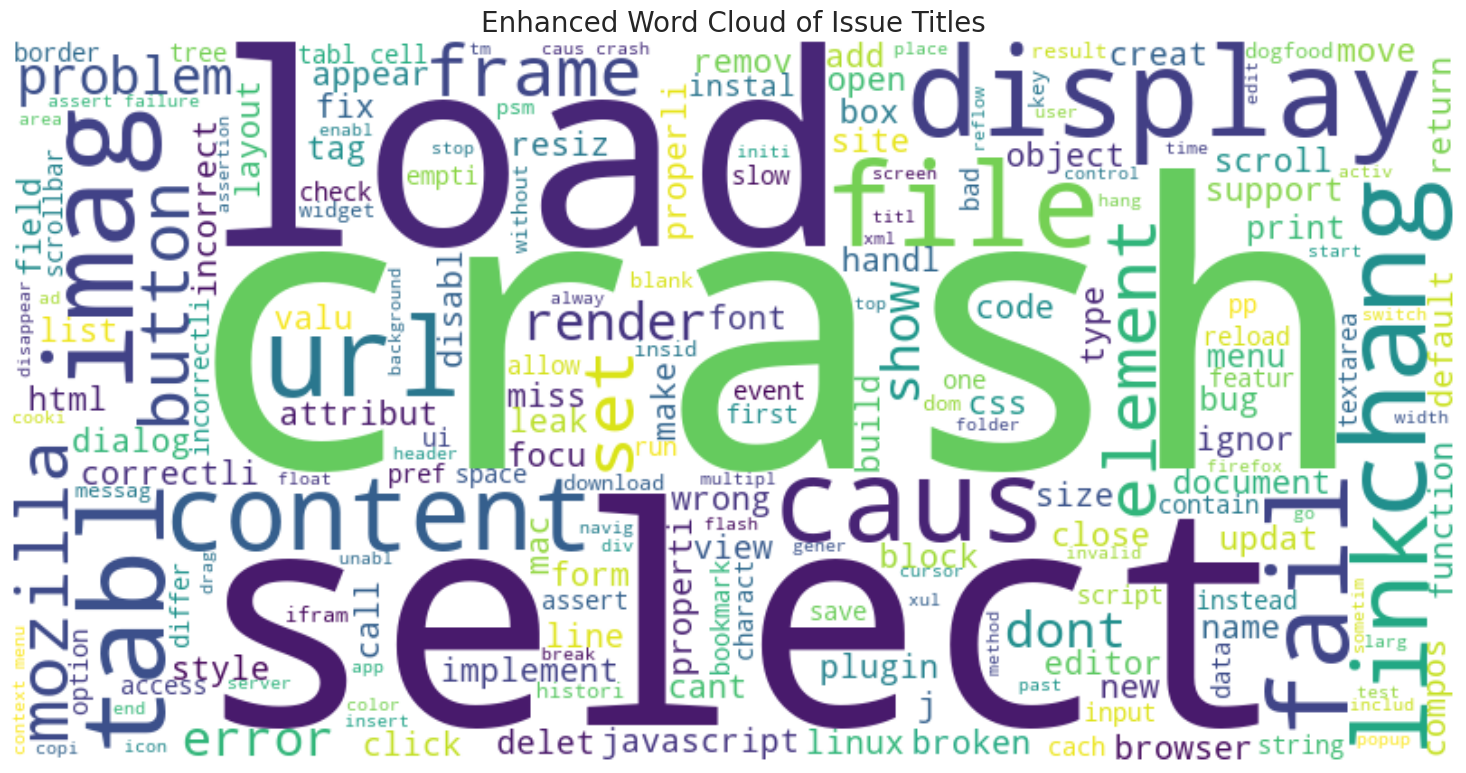

In [43]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Define stopwords and add domain-specific ones
stopwords = set(STOPWORDS)
stopwords.update(["use", "doesnt", "need", "page", "work", "window", "text", "tab"])

# Create the text from the cleaned_title column
all_text = ' '.join(data['cleaned_title'])

# Generate the word cloud
wordcloud = WordCloud(
    stopwords=stopwords,
    background_color='white',
    max_words=200,
    width=800,
    height=400,
    contour_width=3,  # Add contour
    contour_color='steelblue'  # Set contour color
).generate(all_text)

# Plot the word cloud
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Enhanced Word Cloud of Issue Titles', fontsize=20)
plt.tight_layout()
plt.show()


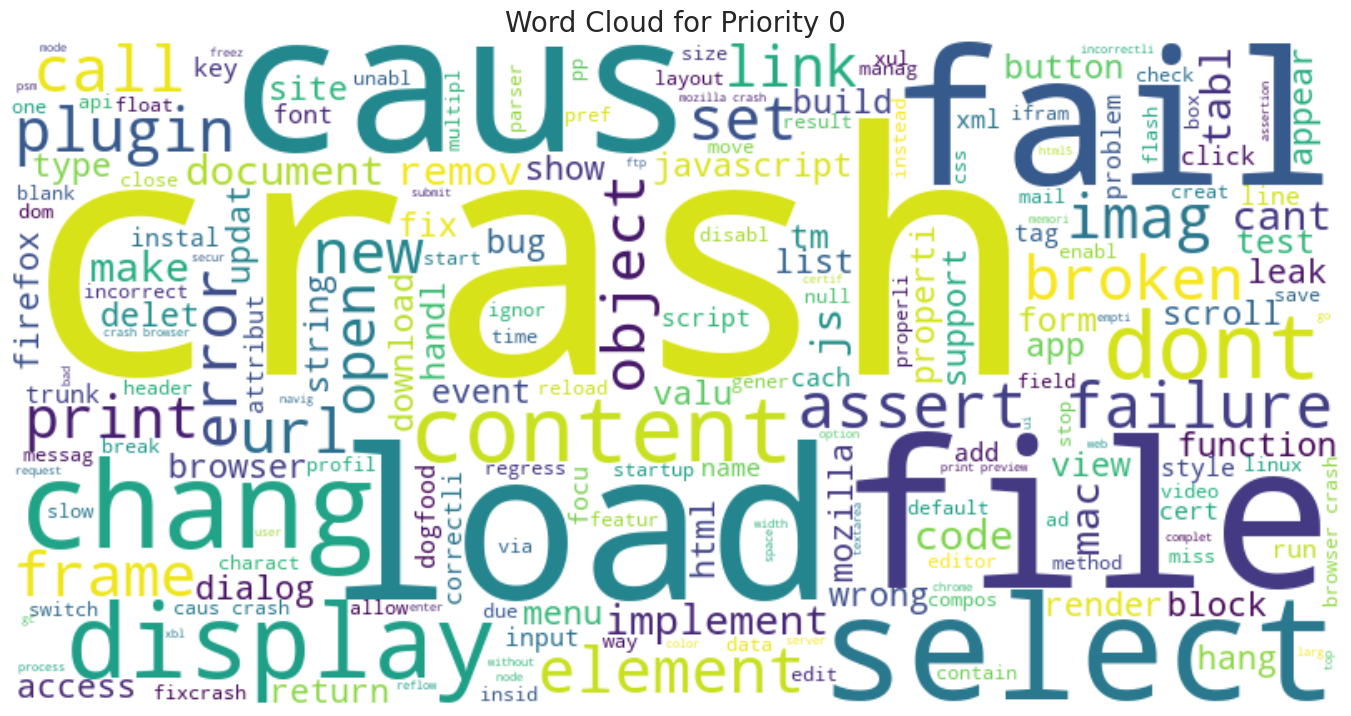

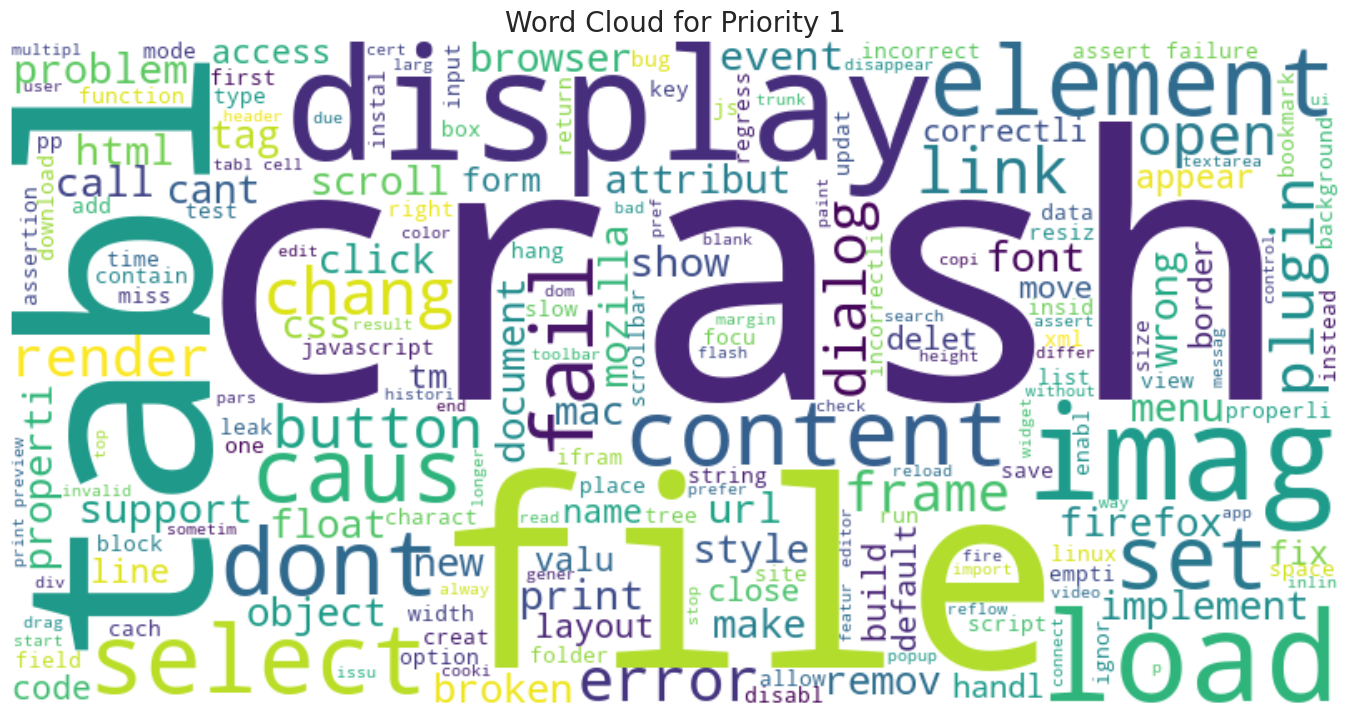

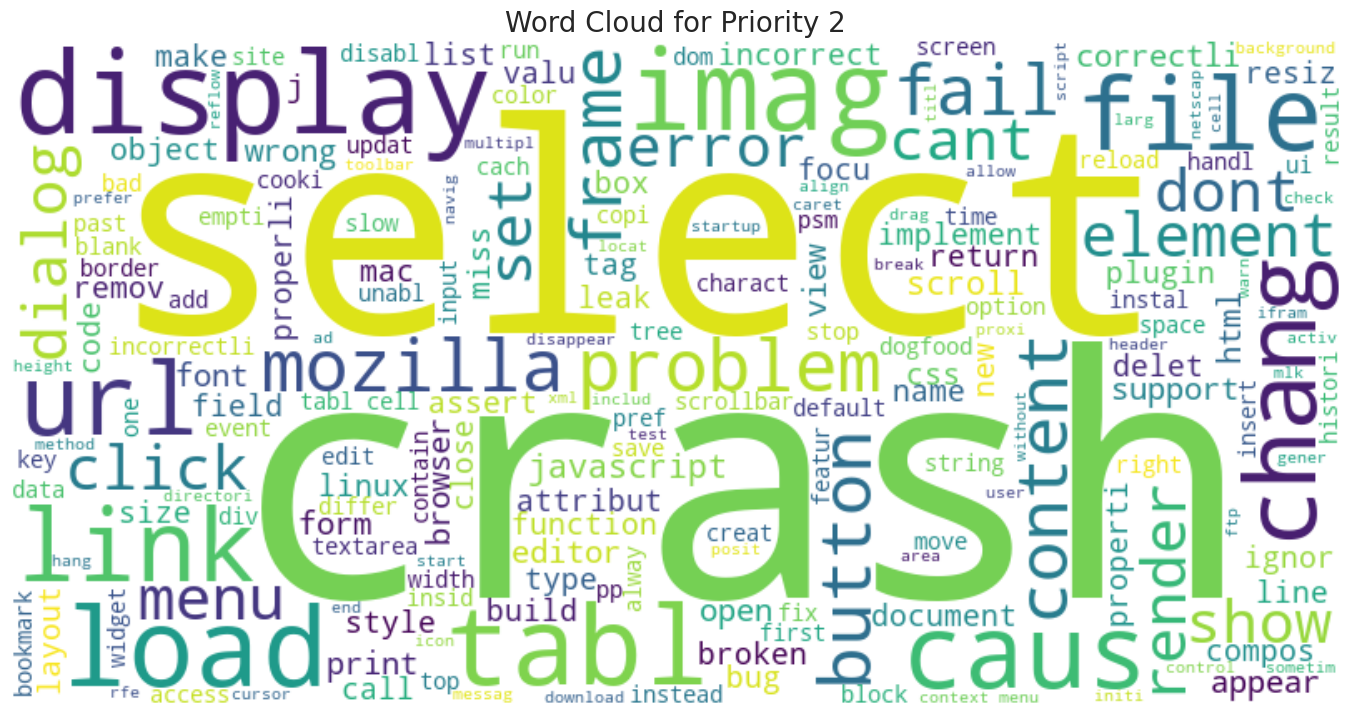

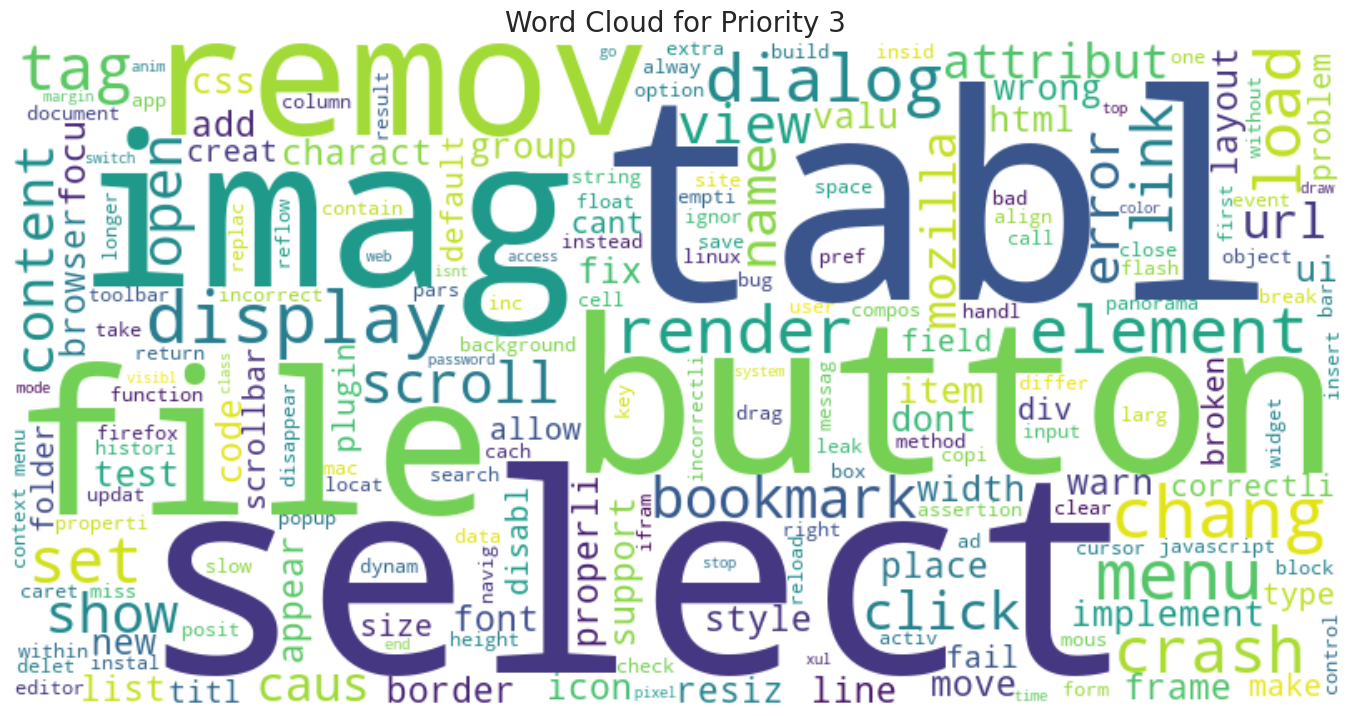

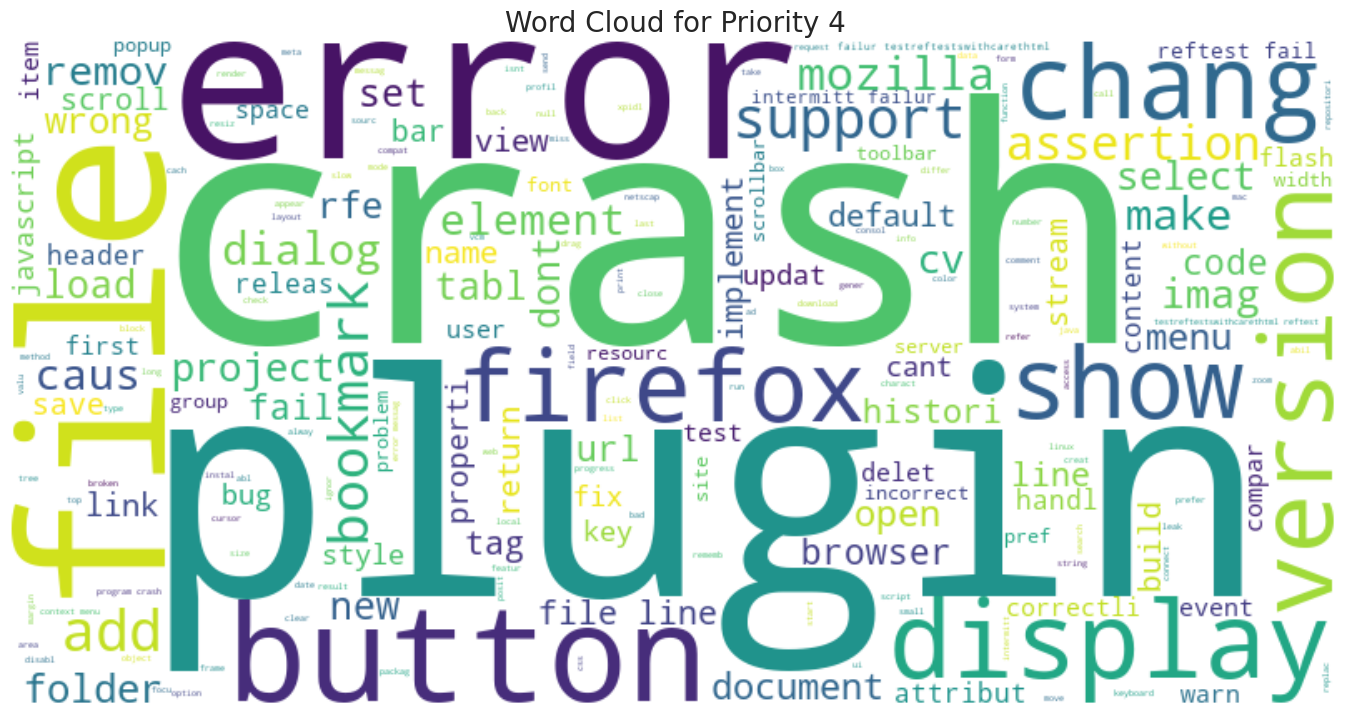

In [44]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Define stopwords and add custom ones
stopwords = set(STOPWORDS)
stopwords.update(["use", "doesnt", "need", "page", "work", "window", "text", "tab"])

# Get unique priorities
priorities = sorted(data['Priority'].unique())  # Ensure priorities are sorted

# Generate word cloud for each priority
for p in priorities:
    text = ' '.join(data[data['Priority'] == p]['cleaned_title'])
    
    # Skip if no text for this priority
    if not text.strip():
        print(f"No data for Priority {p}. Skipping...")
        continue
    
    # Generate the word cloud
    wordcloud = WordCloud(
        stopwords=stopwords,
        width=800,
        height=400,
        background_color='white',
        max_words=200
    ).generate(text)
    
    # Plot the word cloud
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Priority {p}', fontsize=20)
    plt.tight_layout()
    plt.show()


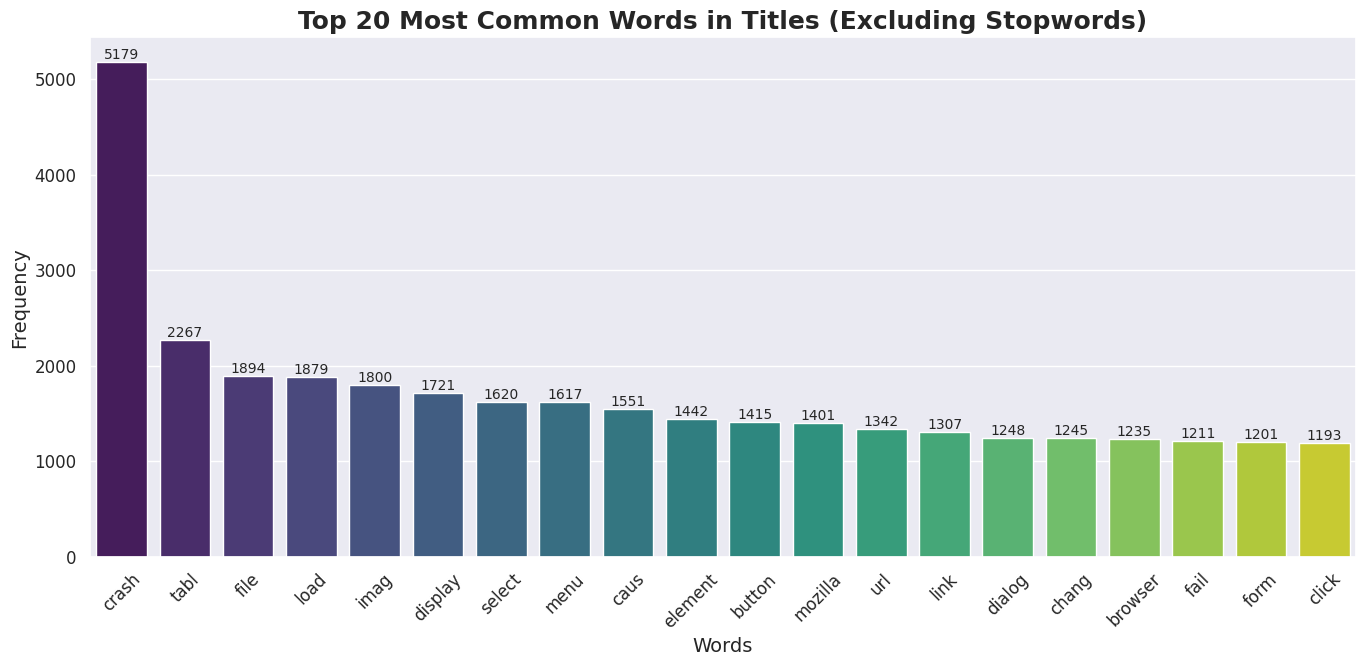

In [45]:
from collections import Counter
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns

# Define stopwords and add custom domain-specific words
stopwords = set(STOPWORDS)
stopwords.update(["use", "doesnt", "need", "page", "work", "window", "text", "tab"])

# Preprocess the words by removing stopwords
filtered_words = [
    word for word in ' '.join(data['cleaned_title']).split() if word.lower() not in stopwords
]

# Count the frequency of words
word_freq = Counter(filtered_words)

# Top n most common words
top_n = 20
common_words = word_freq.most_common(top_n)

# Unpack words and their counts
words, counts = zip(*common_words)

# Create the bar plot
plt.figure(figsize=(14, 7))
ax = sns.barplot(x=list(words), y=list(counts), palette="viridis")

# Add data labels on top of each bar
for i in ax.containers:
    ax.bar_label(i, fmt='%d', label_type='edge', fontsize=10)

# Add title and labels
plt.title(f'Top {top_n} Most Common Words in Titles (Excluding Stopwords)', fontsize=18, fontweight='bold')
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Adjust tick rotation and layout
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()


## Description

In [46]:
data.columns

Index(['Issue_id', 'Component', 'Title', 'Description', 'Status', 'Resolution',
       'Priority', 'cleaned_title', 'title_length', 'word_count', 'polarity'],
      dtype='object')

In [47]:
# Fill null values with empty strings
data['Description'] = data['Description'].fillna('')


In [48]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
import nltk

# Download required NLTK data if not already present
nltk.download('stopwords')

# Initialize stopwords and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
def preprocess_description_temp(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove links
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Remove unwanted punctuations
    punct_to_keep = [':', '>', '<', '=']
    punctuations = string.punctuation
    punct_to_remove = ''.join([p for p in punctuations if p not in punct_to_keep])
    text = text.translate(str.maketrans('', '', punct_to_remove))
    
    # Tokenize text
    words = text.split()
    
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    
    return words


In [50]:
data['description_words'] = data['Description'].apply(preprocess_description_temp)


In [51]:
# Flatten the list of lists into a single list of words
all_description_words = [word for words_list in data['description_words'] for word in words_list]

description_word_freq = Counter(all_description_words)
rare_description_words = set(word for word, freq in description_word_freq.items() if freq == 1)


In [52]:
def preprocess_description(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove links
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Remove unwanted punctuations
    punct_to_keep = [':', '>', '<', '=']
    punctuations = string.punctuation
    punct_to_remove = ''.join([p for p in punctuations if p not in punct_to_keep])
    text = text.translate(str.maketrans('', '', punct_to_remove))
    
    # Tokenize text
    words = text.split()
    
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    
    # Remove rare words
    words = [word for word in words if word not in rare_description_words]
    
    # Perform stemming
    stemmed_words = [stemmer.stem(word) for word in words]
    
    # Reconstruct the text
    text = ' '.join(stemmed_words)
    
    return text
data['cleaned_description'] = data['Description'].apply(preprocess_description)


In [53]:
for i in range(3):
    print(f"Original Description {i+1}:\n{data['Description'].iloc[i]}\n")
    print(f"Cleaned Description {i+1}:\n{data['cleaned_description'].iloc[i]}\n")


Original Description 1:
There is a piece of code in the Windows GFX that rounds the font size in the; same way as Netscape 4.X. The problem is that this code ends up rounding 9px; down to 8px; which is illegible.

Cleaned Description 1:
piec code window gfx round font size way netscap 4x problem code end round 9px 8px illeg

Original Description 2:
We need to land OOP plugins in mozilla-central; preffed off by default. There are some blockers well need to deal with first.

Cleaned Description 2:
need land oop plugin mozillacentr pref default blocker well need deal first

Original Description 3:
(This bug imported from BugSplat; Netscapes internal bugsystem.  It; was known there as bug #358181; http://scopus.netscape.com/bugsplat/show_bug.cgi?id=358181; Imported into Bugzilla on 07/15/99 22:30); ; The XPCOM Proxy code crashes when trying to marhal or autoproxy a parameter that; there isnt a typelib for.  It should instead return a Proxy error nsresult.; Perhaps NS_ERROR_PROXY_INVALID_PA

In [54]:
data['description_length'] = data['cleaned_description'].apply(len)
data['description_word_count'] = data['cleaned_description'].apply(lambda x: len(x.split()))
data[['description_length', 'description_word_count']].head()


description_length  description_word_count
0                  88                      17
1                  75                      12
2                 207                      31
3                 487                      74
4                 626                     116

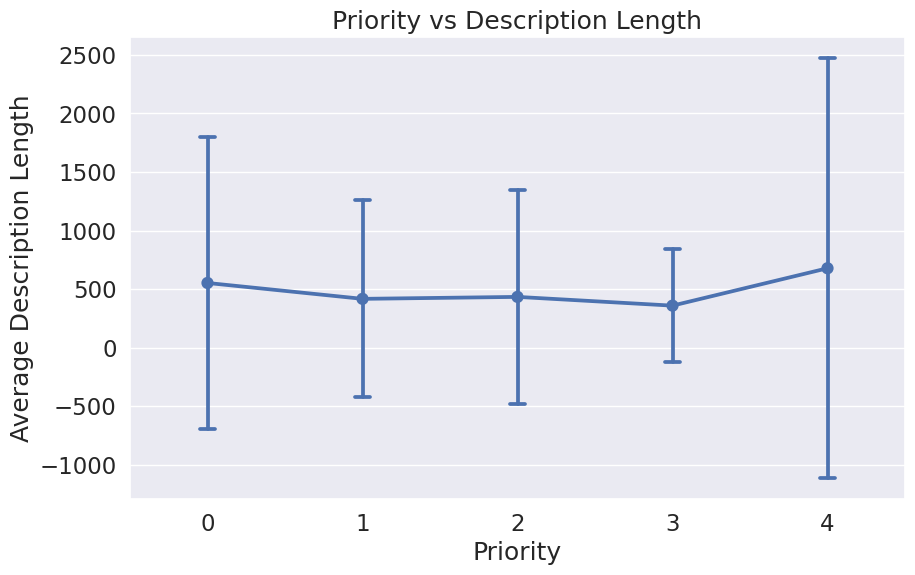

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
data['Priority'] = data['Priority'].astype(str)
plt.figure(figsize=(10,6))
sns.pointplot(x='Priority', y='description_length', data=data, ci='sd', capsize=0.1)
plt.title('Priority vs Description Length')
plt.xlabel('Priority')
plt.ylabel('Average Description Length')
plt.show()


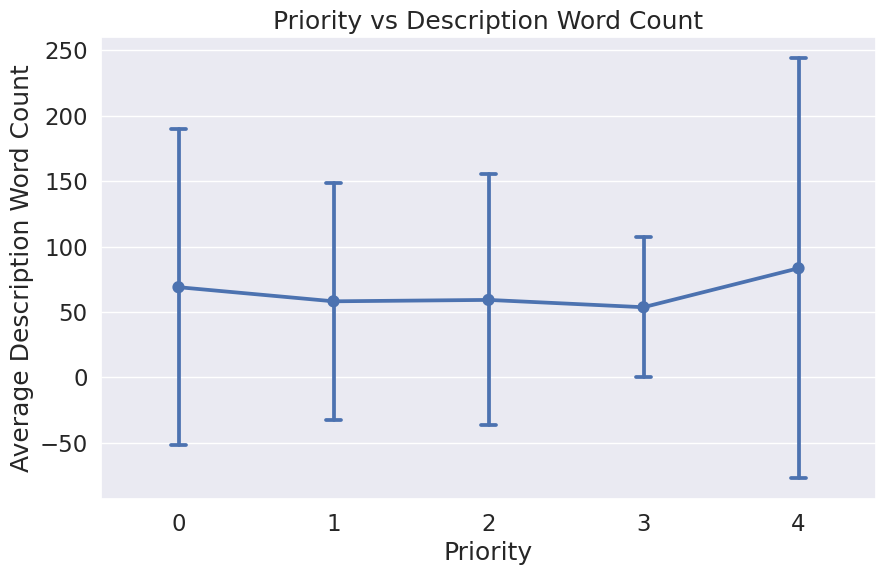

In [56]:
plt.figure(figsize=(10,6))
sns.pointplot(x='Priority', y='description_word_count', data=data, ci='sd', capsize=0.1)
plt.title('Priority vs Description Word Count')
plt.xlabel('Priority')
plt.ylabel('Average Description Word Count')
plt.show()


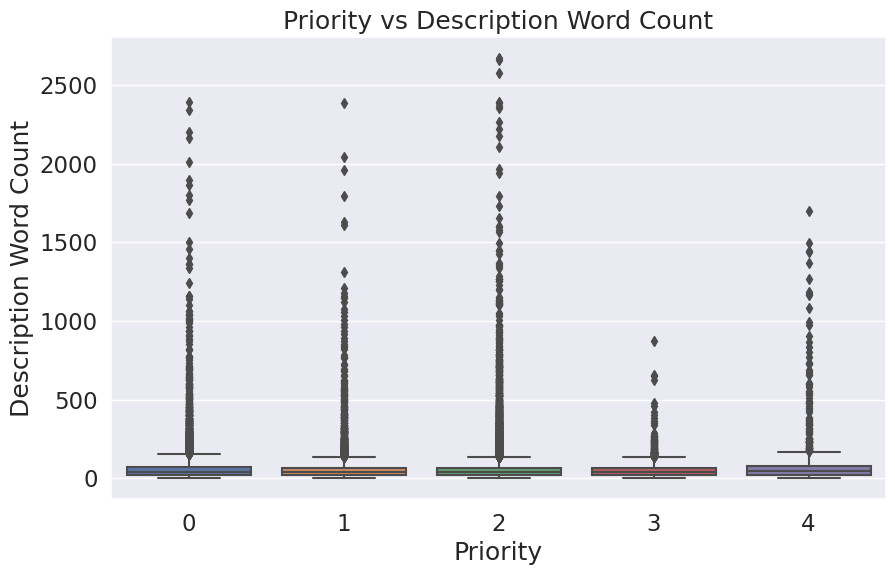

In [57]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Priority', y='description_word_count', data=data)
plt.title('Priority vs Description Word Count')
plt.xlabel('Priority')
plt.ylabel('Description Word Count')
plt.show()


In [58]:
data.columns

Index(['Issue_id', 'Component', 'Title', 'Description', 'Status', 'Resolution',
       'Priority', 'cleaned_title', 'title_length', 'word_count', 'polarity',
       'description_words', 'cleaned_description', 'description_length',
       'description_word_count'],
      dtype='object')

# Preprocessing Test data

In [59]:
# Fill null values with empty strings
test['Description'] = test['Description'].fillna('')
# Ensure required libraries are imported
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

# Initialize stopwords and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Reuse rare_words from training data preprocessing
# Assuming 'rare_words' is available from previous steps

def preprocess_title_stemmer_test(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove links
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Remove unwanted punctuations
    punct_to_keep = [':', '>', '<', '=']
    punctuations = string.punctuation
    punct_to_remove = ''.join([p for p in punctuations if p not in punct_to_keep])
    text = text.translate(str.maketrans('', '', punct_to_remove))
    
    # Tokenize text
    words = text.split()
    
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    
    # Remove rare words based on training data
    words = [word for word in words if word not in rare_words]
    
    # Apply stemming
    stemmed_words = [stemmer.stem(word) for word in words]
    
    # Reconstruct the text
    text = ' '.join(stemmed_words)
    
    return text

# Apply the preprocessing function to 'Title' in test data
test['cleaned_title'] = test['Title'].apply(preprocess_title_stemmer_test)


In [60]:
from textblob import TextBlob

# Calculate title length and word count
test['title_length'] = test['cleaned_title'].apply(len)
test['word_count'] = test['cleaned_title'].apply(lambda x: len(x.split()))

# Calculate polarity
test['polarity'] = test['cleaned_title'].apply(lambda x: TextBlob(x).sentiment.polarity)


In [61]:
# Assuming 'rare_description_words' is available from previous steps

def preprocess_description_test(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove links
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Remove unwanted punctuations
    punct_to_keep = [':', '>', '<', '=']
    punctuations = string.punctuation
    punct_to_remove = ''.join([p for p in punctuations if p not in punct_to_keep])
    text = text.translate(str.maketrans('', '', punct_to_remove))
    
    # Tokenize text
    words = text.split()
    
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    
    # Remove rare words based on training data
    words = [word for word in words if word not in rare_description_words]
    
    # Perform stemming
    stemmed_words = [stemmer.stem(word) for word in words]
    
    # Reconstruct the text
    text = ' '.join(stemmed_words)
    
    return text

# Apply the preprocessing function to 'Description' in test data
test['cleaned_description'] = test['Description'].apply(preprocess_description_test)


In [62]:
# Calculate description length and word count
test['description_length'] = test['cleaned_description'].apply(len)
test['description_word_count'] = test['cleaned_description'].apply(lambda x: len(x.split()))


In [63]:
test['Usage'] = 'Test'


In [64]:
from sklearn.model_selection import train_test_split

# Split the data
train_data, valid_data = train_test_split(
    data,
    test_size=0.2,
    stratify=data['Priority'],
    random_state=42
)

# Avoid SettingWithCopyWarning by creating copies
train_data = train_data.copy()
valid_data = valid_data.copy()

# Assign 'Usage' labels
train_data['Usage'] = 'Train'
valid_data['Usage'] = 'Valid'

# Combine 'Train' and 'Valid' data
data_combined = pd.concat([train_data, valid_data], ignore_index=True)


In [65]:
import numpy as np

# Identify columns present in training but not in test data
missing_cols_in_test = set(data_combined.columns) - set(test.columns)
for col in missing_cols_in_test:
    if col != 'Priority':  # 'Priority' doesn't exist in test data
        test[col] = np.nan

# Ensure the columns are in the same order
test = test[data_combined.columns.drop('Priority')]  # Exclude 'Priority' for test data
test['Priority'] = np.nan  # Add 'Priority' column at the end

# Rearrange columns to match data_combined
test = test[data_combined.columns]


In [66]:
test.head()

Issue_id               Component  \
0      6578       JavaScript Engine   
1      8050       Networking: Cache   
2      5281        DOM: Core & HTML   
3      7871  Layout: View Rendering   
4      2411                Plug-ins   

                                               Title  \
0    Finalize yield syntax to match ES4/JS2 proposal   
1               e10s HTTP: offline application cache   
2  [FIX]Add GetOwnerDocument on nsIContent or nsG...   
3  Text editing broken in Firebug edit mode and o...   
4  shockwave movies redraw improperly on mac(nsbe...   

                                         Description    Status Resolution  \
0  This tracks Python 2.5.  Currently we allow; ;...  VERIFIED      FIXED   
1  I actually know very little about how applicat...  RESOLVED      FIXED   
2  See comments in bug 211440; the idea is to add...  RESOLVED      FIXED   
3  Getting reports that editing is broken in Fire...  VERIFIED      FIXED   
4  From Bugzilla Helper:; User-Agent: Mozilla/4.7...  VERIFIED  DUPLICATE   

   Priority                                   cleaned_title  title_length  \
0       NaN                 final yield syntax match propos            31   
1       NaN                          e10 offlin applic cach            22   
2       NaN         fixadd getownerdocu nsicont nsgenericel            39   
3       NaN       text edit broken firebug edit mode extens            41   
4       NaN  shockwav movi redraw improperli macnsbeta3 rtm            46   

   word_count  polarity  description_words  \
0           5       0.0                NaN   
1           4       0.0                NaN   
2           4       0.0                NaN   
3           7      -0.4                NaN   
4           6       0.0                NaN   

                                 cleaned_description  description_length  \
0  track python 25 current allow function f yield...                 136   
1  actual know littl applic cach offlin mode etc ...                 295   
2  see comment bug 211440 idea add alreadyaddrefe...                 235   
3  get report edit broken html style dom editor a...                 331   
4  bugzilla helper: useragent: mozilla475 macinto...                 418   

   description_word_count Usage  
0                      25  Test  
1                      52  Test  
2                      33  Test  
3                      55  Test  
4                      59  Test

In [67]:
# Combine the datasets
full_data = pd.concat([data_combined, test], ignore_index=True)


In [68]:
# Save to CSV
full_data.to_csv('combined_data.csv', index=False)


# Modeling

In [69]:
# Assume 'full_data' is your combined DataFrame with the 'Usage' column
# We'll select only the data with labels (exclude test data)

# Select training data
train_df = full_data[full_data['Usage'] == 'Train'].copy()

# Select validation data
valid_df = full_data[full_data['Usage'] == 'Valid'].copy()

# Ensure that the 'Priority' column is of integer type
train_df['Priority'] = train_df['Priority'].astype(int)
valid_df['Priority'] = valid_df['Priority'].astype(int)

# Class distribution in training set
train_class_distribution = train_df['Priority'].value_counts(normalize=True)
print("Training Set Class Distribution:\n", train_class_distribution)

# Class distribution in validation set
valid_class_distribution = valid_df['Priority'].value_counts(normalize=True)
print("\nValidation Set Class Distribution:\n", valid_class_distribution)


Training Set Class Distribution:
 Priority
2    0.587876
1    0.177615
0    0.168746
3    0.043165
4    0.022597
Name: proportion, dtype: float64

Validation Set Class Distribution:
 Priority
2    0.587886
1    0.177564
0    0.168790
3    0.043117
4    0.022644
Name: proportion, dtype: float64


In [70]:
# Find the majority class in the training set
majority_class = train_df['Priority'].mode()[0]
print("\nMajority Class in Training Set:", majority_class)

from sklearn.metrics import f1_score, classification_report

# Create a list of predictions (always predicting the majority class)
predictions = [majority_class] * len(valid_df)

# Calculate the F1 score (using 'macro' average since it's multi-class)
f1 = f1_score(valid_df['Priority'], predictions, average='macro')
print("\nF1 Score (Macro) when always predicting the majority class (%d): %.3f" % (majority_class, f1))

# Detailed classification report
print("\nClassification Report:\n")
print(classification_report(valid_df['Priority'], predictions))



Majority Class in Training Set: 2

F1 Score (Macro) when always predicting the majority class (2): 0.148

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1789
           1       0.00      0.00      0.00      1882
           2       0.59      1.00      0.74      6231
           3       0.00      0.00      0.00       457
           4       0.00      0.00      0.00       240

    accuracy                           0.59     10599
   macro avg       0.12      0.20      0.15     10599
weighted avg       0.35      0.59      0.44     10599



## Xg-boost

In [71]:
# Convert categorical features to 'category' data type
full_data['Component'] = full_data['Component'].astype('category')
full_data['Status'] = full_data['Status'].astype('category')
full_data['Resolution'] = full_data['Resolution'].astype('category')

# Replace categorical strings with their numerical codes
full_data['Component'] = full_data['Component'].cat.codes
full_data['Status'] = full_data['Status'].cat.codes
full_data['Resolution'] = full_data['Resolution'].cat.codes


In [72]:
# Separate data into training and validation sets
train_df = full_data[full_data['Usage'] == 'Train'].copy()
valid_df = full_data[full_data['Usage'] == 'Valid'].copy()

# Extract labels from the training and validation sets
y_train = train_df['Priority'].astype(int)
y_valid = valid_df['Priority'].astype(int)

# List of columns to drop
columns_to_drop = [
    'Issue_id', 'Title', 'Description', 'cleaned_title', 'cleaned_description',
    'Priority', 'Usage', 'description_words', 'polarity','description_length','title_length'
]

# Drop text features, label, and 'Usage' column from training data
X_train = train_df.drop(columns=columns_to_drop)

# Drop text features, label, and 'Usage' column from validation data
X_valid = valid_df.drop(columns=columns_to_drop)


In [73]:
# Display the first few rows of the training data
print("Training Data Features:\n", X_train.head())
# Check data types of features
print("\nData Types of Training Features:\n", X_train.dtypes)


Training Data Features:
    Component  Status  Resolution  word_count  description_word_count
0          4       1           2           3                      15
1        174       1           2           7                     125
2        145       1           2           4                     108
3          4       2           8           7                      15
4          4       2           4           2                      69

Data Types of Training Features:
 Component                 int16
Status                     int8
Resolution                 int8
word_count                int64
description_word_count    int64
dtype: object


In [74]:
from xgboost import XGBClassifier


In [75]:
# Determine the number of classes
num_classes = full_data['Priority'].nunique()

# Create an instance of the XGBClassifier with multi-class parameters
model = XGBClassifier(
    objective='multi:softprob',  # For multi-class classification with probability outputs
    num_class=num_classes,
    eval_metric='mlogloss',     # Evaluation metric for multi-class
    use_label_encoder=False,
    random_state=42
)


In [76]:
# Train the model on the training set
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [77]:
# Use the trained model to predict the labels for the validation set
predictions = model.predict(X_valid)


In [78]:
from sklearn.metrics import f1_score, classification_report

# Calculate the F1 score
f1 = f1_score(y_true=y_valid, y_pred=predictions, average='macro')

print('Using XGBoost on non-text features...')
print('\nF1 Score (Macro): %.3f' % f1)


Using XGBoost on non-text features...

F1 Score (Macro): 0.353


In [79]:
# Print the classification report
print('\nClassification Report:\n')
print(classification_report(y_valid, predictions))



Classification Report:

              precision    recall  f1-score   support

           0       0.46      0.30      0.36      1789
           1       0.39      0.19      0.26      1882
           2       0.68      0.91      0.78      6231
           3       0.43      0.06      0.10       457
           4       0.48      0.18      0.27       240

    accuracy                           0.63     10599
   macro avg       0.49      0.33      0.35     10599
weighted avg       0.58      0.63      0.58     10599



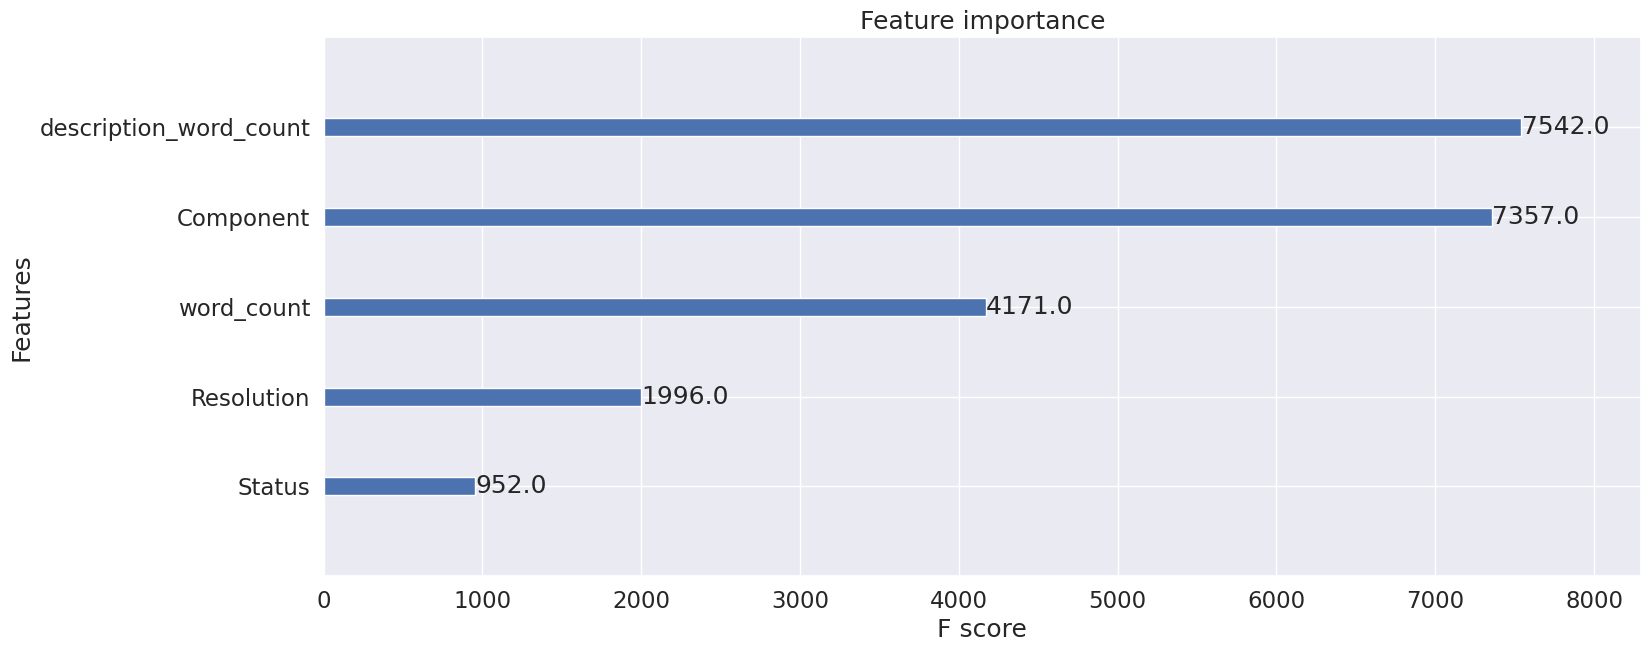

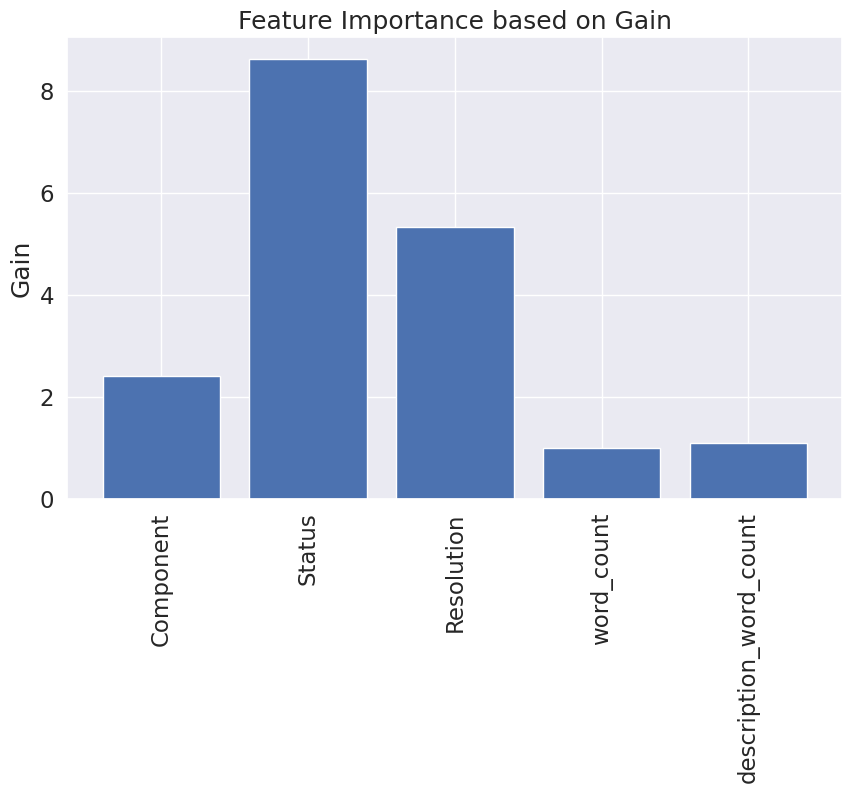

In [80]:
from xgboost import plot_importance
from matplotlib import pyplot

# Plot feature importance based on weight
plot_importance(model)
pyplot.show()

# Alternatively, get feature importance based on gain
feat_gains = model.get_booster().get_score(importance_type='gain')

# Plot the feature gains
pyplot.figure(figsize=(10, 6))
pyplot.bar(feat_gains.keys(), feat_gains.values())
pyplot.xticks(rotation=90)
pyplot.title('Feature Importance based on Gain')
pyplot.ylabel('Gain')
pyplot.show()


## Lgbm

In [81]:
import lightgbm as lgb
from sklearn.metrics import f1_score, classification_report


In [82]:
# Create LightGBM datasets
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid)

# Set parameters for multi-class classification
lgb_params = {
    'objective': 'multiclass',
    'num_class': num_classes,
    'metric': 'multi_logloss',
    'random_state': 42
}

# Train the model
lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    num_boost_round=100
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 446
[LightGBM] [Info] Number of data points in the train set: 42395, number of used features: 5
[LightGBM] [Info] Start training from score -1.779359
[LightGBM] [Info] Start training from score -1.728135
[LightGBM] [Info] Start training from score -0.531239
[LightGBM] [Info] Start training from score -3.142714
[LightGBM] [Info] Start training from score -3.789938


In [83]:
# Predict on the validation set
lgb_pred = lgb_model.predict(X_valid)
lgb_pred_classes = lgb_pred.argmax(axis=1)  # Get class with highest probability

# Evaluate the model

f1 = f1_score(y_valid, lgb_pred_classes, average='macro')
print('LightGBM Model')
print('F1 Score (Macro): %.3f' % f1)
print('\nClassification Report:\n')
print(classification_report(y_valid, lgb_pred_classes))


LightGBM Model
F1 Score (Macro): 0.355

Classification Report:

              precision    recall  f1-score   support

           0       0.49      0.30      0.37      1789
           1       0.41      0.19      0.25      1882
           2       0.68      0.93      0.78      6231
           3       0.54      0.06      0.10       457
           4       0.49      0.18      0.26       240

    accuracy                           0.63     10599
   macro avg       0.52      0.33      0.36     10599
weighted avg       0.59      0.63      0.58     10599



## Catboost

In [84]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, classification_report
# If using original categorical features:
# categorical_features = ['Component', 'Status', 'Resolution']

# If using encoded features (since we've encoded them), specify empty list
categorical_features_indices = []


In [85]:
# Initialize CatBoostClassifier
cat_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    loss_function='MultiClass',
    eval_metric='TotalF1',
    random_seed=42,
    verbose=False
)

# Train the model
cat_model.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    early_stopping_rounds=10,
    use_best_model=True
)


In [86]:
# Predict on the validation set
cat_pred = cat_model.predict(X_valid)
cat_pred = cat_pred.flatten().astype(int)  # Convert predictions to integer labels

# Evaluate the model
f1 = f1_score(y_valid, cat_pred, average='macro')
print('CatBoost Model')
print('F1 Score (Macro): %.3f' % f1)
print('\nClassification Report:\n')
print(classification_report(y_valid, cat_pred))


CatBoost Model
F1 Score (Macro): 0.269

Classification Report:

              precision    recall  f1-score   support

           0       0.49      0.28      0.36      1789
           1       0.36      0.11      0.17      1882
           2       0.66      0.94      0.77      6231
           3       0.71      0.02      0.04       457
           4       0.00      0.00      0.00       240

    accuracy                           0.62     10599
   macro avg       0.44      0.27      0.27     10599
weighted avg       0.56      0.62      0.55     10599



## Tuning LGBM

In [87]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
# Define the parameter grid
param_grid = {
    'num_leaves': [31, 63],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.1, 0.01],
    'min_child_samples': [20, 40],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}

lgb_estimator = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=num_classes,
    metric='multi_logloss',
    random_state=42
)


In [88]:
grid_search = GridSearchCV(
    estimator=lgb_estimator,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 384 candidates, totalling 1152 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 28263, number of used features: 5
[LightGBM] [Info] Start training from score -1.779417
[LightGBM] [Info] Start training from score -1.728124
[LightGBM] [Info] Start training from score -0.531248
[LightGBM] [Info] Start training from score -3.142703
[LightGBM] [Info] Start training from score -3.789404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 433
[LightGBM] [Info] Number of data points in the train set: 28263, number of used features: 5
[LightGBM] [Info] Start training from score -1.779417
[LightGBM] [Info] Start training from 

GridSearchCV(cv=3,
             estimator=LGBMClassifier(metric='multi_logloss', num_class=5,
                                      objective='multiclass', random_state=42),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.1, 0.01],
                         'max_depth': [-1, 10, 20],
                         'min_child_samples': [20, 40], 'num_leaves': [31, 63],
                         'reg_alpha': [0, 0.1], 'reg_lambda': [0, 0.1],
                         'subsample': [0.8, 1.0]},
             scoring='f1_macro', verbose=1)

In [89]:
print('Best Parameters:', grid_search.best_params_)
print('Best F1 Score:', grid_search.best_score_)
# Get the best estimator
best_lgb_model = grid_search.best_estimator_

# Predict on validation set
best_lgb_pred = best_lgb_model.predict(X_valid)

# Evaluate the model
f1 = f1_score(y_valid, best_lgb_pred, average='macro')
print('Tuned LightGBM Model')
print('F1 Score (Macro): %.3f' % f1)
print('\nClassification Report:\n')
print(classification_report(y_valid, best_lgb_pred))


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 20, 'num_leaves': 63, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.8}
Best F1 Score: 0.34679685022932283
Tuned LightGBM Model
F1 Score (Macro): 0.350

Classification Report:

              precision    recall  f1-score   support

           0       0.47      0.31      0.37      1789
           1       0.39      0.18      0.25      1882
           2       0.68      0.91      0.78      6231
           3       0.46      0.05      0.10       457
           4       0.46      0.17      0.25       240

    accuracy                           0.63     10599
   macro avg       0.49      0.33      0.35     10599
weighted avg       0.58      0.63      0.58     10599

